## Reloading data from previous exercice. Please enter the proper path to exercice as the example below

| Date                |   Copper |   Aluminum |   Zinc |   Lead |   Tin |   Oil Futures |
|:--------------------|---------:|-----------:|-------:|-------:|------:|--------------:|
| 2010-01-01 00:00:00 |     7375 |       2230 |   2560 | 2432   | 16950 |         79.36 |
| 2010-01-04 00:00:00 |     7500 |       2267 |   2574 | 2515   | 17450 |         81.51 |
| 2010-01-05 00:00:00 |     7485 |       2302 |   2575 | 2522.5 | 17375 |         81.77 |
| 2010-01-06 00:00:00 |     7660 |       2377 |   2718 | 2680   | 17825 |         83.18 |
| 2010-01-07 00:00:00 |     7535 |       2310 |   2607 | 2599   | 17475 |         82.66 |
| Date                |   Copper |   Aluminum |   Zinc |   Lead |   Tin |   Oil Futures |
|:--------------------|---------:|-----------:|-------:|-------:|------:|--------------:|
| 2021-01-01 00:00:00 |     7766 |     1979.5 |   2751 |   1994 | 20325 |         48.52 |
| Date                |   Copper |   Aluminum |   Zinc |   Lead |   Tin |   Oil Futures |
|:--------

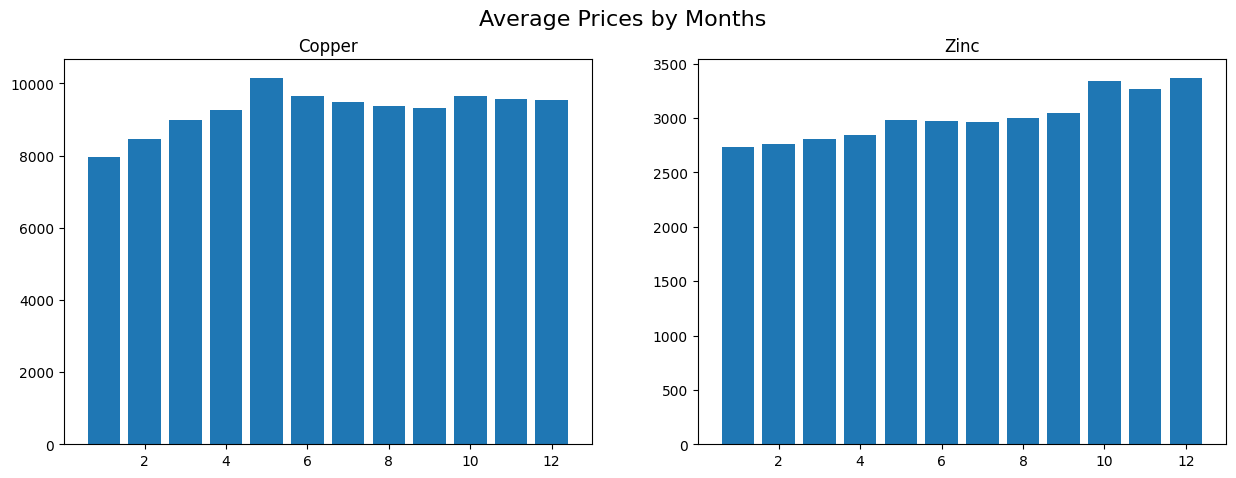

2024-10-04 04:35:53,401 - INFO - Executing add_non_existing_columns
2024-10-04 04:35:53,403 - INFO - Successfully executed add_non_existing_columns in 0.0008 seconds
2024-10-04 04:35:53,414 - INFO - Executing update_indicators
2024-10-04 04:35:53,476 - INFO - Successfully executed update_indicators in 0.0611 seconds
2024-10-04 04:35:53,476 - INFO - Executing update_indicators
2024-10-04 04:35:53,531 - INFO - Successfully executed update_indicators in 0.0539 seconds
2024-10-04 04:35:53,534 - INFO - Executing update_indicators
2024-10-04 04:35:53,593 - INFO - Successfully executed update_indicators in 0.0580 seconds
2024-10-04 04:35:53,601 - INFO - Executing update_indicators


| Date                |   Zinc |   Copper |
|:--------------------|-------:|---------:|
| 2020-01-01 00:00:00 | 2272   |   6174   |
| 2020-01-02 00:00:00 | 2310   |   6188   |
| 2020-01-03 00:00:00 | 2306   |   6129.5 |
| 2020-01-06 00:00:00 | 2324.5 |   6138.5 |
| 2020-01-07 00:00:00 | 2346   |   6149   |


2024-10-04 04:35:53,663 - INFO - Successfully executed update_indicators in 0.0603 seconds


In [1]:
%run "/Users/rayannitcheu/Documents/GitHub/OilDesk-Intern-Assessment/solutions/exercice_3.ipynb"

In [2]:
import numpy as np

from itertools import product
from sklearn.preprocessing import MinMaxScaler

## A First Backtest Strategy

In [21]:
def rebase_df(p, initial_value):
    """
    This function rebase a given df of prices to begin at an initial value chosen by the user.
    """
    
    r = 1 + p.pct_change()
    r.iloc[0] = initial_value
    return r.cumprod()


def compute_annualized_returns(p):
    """
    This function computes the annualized returns for a given df of prices.
    """
    
    r = 1 + p.pct_change()
    r.iloc[0] = 1
    r = ((r.fillna(0)).cumprod()).iloc[-1]
    r = r.apply(lambda x: max(x, 1e-6)) # We're setting a floor at 1e-6 else we obtain a wrong return for prices that went to 0

    return r**(1/252) - 1


def compute_annualized_vol(p):
    """
    This function computes the annualized volatility for a given df of prices.
    """
    
    return p.pct_change().std() * np.sqrt(252)


def compute_dd(p):
    """
    This function computes the maximum drawdown for a given df of prices.
    """
    
    cumulative_max = p.cummax()
    dd = (p - cumulative_max) / cumulative_max
    
    return dd.min()


def compute_annualized_sr(r,
                          v,
                          N):
    """
    This function computes the annualized sharpe ratio for given annualized returns, volatlity and number of days in the strategy.
    """
    
    return np.sqrt(N/252) * r / v


def compute_rolling_returns(p, rolling_window):
    """
    This function computes the rolling returns for a given df of prices and a rolling window.
    """
    
    return p.pct_change(rolling_window)


def compute_rolling_volatility(p, rolling_window):
    """
    This function computes the rolling volatility for a given df of prices and a rolling window.
    """
    
    r = compute_rolling_returns(p, 1)
    
    return r.rolling(rolling_window).std() * np.sqrt(252)


def compute_rolling_sr(rolling_r,
                       rolling_vol,
                       rolling_window):
    
    return np.sqrt(rolling_window/252) * rolling_r / rolling_vol


def compute_rolling_dd(p, rolling_windoww):
    rolling_max = p.rolling(rolling_windoww).max()
    rolling_dd = ((p - rolling_max) / rolling_max)
    return rolling_dd


def compute_statistics(res):
    res_df = pd.DataFrame(columns=res.columns, index=["Returns", "Vol", "SR", "DD"])
    res_df.iloc[0] = compute_annualized_returns(res)
    res_df.iloc[1] = compute_annualized_vol(res)
    res_df.iloc[2] = compute_annualized_sr(res_df.iloc[0], res_df.iloc[1], res.shape[0])
    res_df.iloc[3] = compute_dd(res)

    pretty_print(res_df)

    return res_df

def compute_rolling_statistic(res, rolling_window, plot=True):
    r = compute_rolling_returns(res, rolling_window)
    v = compute_rolling_volatility(res, rolling_window)
    sr = compute_rolling_sr(r, v, rolling_window)
    dd = compute_rolling_dd(res, rolling_window)

    if plot:
        cm = 1 / 2.54
        fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(40 * cm, 20 * cm))
        fig.suptitle(f'Rolling Statistics with window = {rolling_window} days', fontsize=16)
        axs[0].plot(r.index, r.values, c='blue')
        axs[0].set_title("Rolling Returns")
        axs[1].plot(v.index, v.values, c='red')
        axs[1].set_title("Rolling Volatilty")
        axs[2].plot(sr.index, sr.values, c='green')
        axs[2].set_title("Rolling Sharpe")
        axs[3].plot(dd.index, dd.values, c='brown')
        axs[3].set_title("Rolling DD")
        plt.show()

    return r, v, sr, dd

def compute_mean_holding_period(turnover):
    pass

def plot_return_distribution(res, rolling_window):
    pass

def rsi_backtester(prices,  **kwargs):

    params = {
        'start_dt': prices.index[0],
        'end_dt': prices.index[-1],
        'initial_value': 1e6,
        'tc': 0.001,  # coût de transaction
        'rsi_window': 14,
        'leverage': 1,  # effet de levier
        'long_threshold': 30,  # seuil pour le RSI long
        'short_threshold': 70,  # seuil pour le RSI short
    }

    params.update(kwargs)

    p = prices.copy()
    p = p[(p.index >= params.get("start_dt")) & (p.index <= params.get("end_dt"))]

    commodities_list = p.columns
    rsi_list = [f"{commo}-RSI" for commo in commodities_list]

    rsi = calculate_rsi(p, commodities_list, window=params.get("rsi_window"))[rsi_list]

    long_mask = ~ (rsi < params.get("long_threshold"))
    short_mask = ~ (rsi > params.get("short_threshold"))
    neutral_mask = ~ ((rsi <= params.get("short_threshold")) & (rsi >= params.get("long_threshold")))

    signals = rsi.where(short_mask, - 1 * params.get("leverage")).where(long_mask,  1 * params.get("leverage")).where(neutral_mask, 0)
    signals = signals.iloc[params.get("rsi_window"):, :].shift(1).fillna(0)
    turnover = signals.diff().abs()

    returns = p.pct_change().iloc[params.get("rsi_window"):, :]
    returns.columns = rsi_list

    dP = 1 + returns * signals
    dP_tc = 1 + (returns * signals - turnover * params.get("tc"))

    dP.iloc[0] = params.get("initial_value")
    dP_tc.iloc[0] = params.get("initial_value")

    res = dP.cumprod()
    res_tc = dP_tc.cumprod()

    res = res.where(res > 0, 0)
    res_tc = res_tc.where(res_tc > 0, 0)

    return res, res_tc, signals, turnover


def hyperoptimisation(prices, param_grid, w_sr, w_dd):
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    default_params = {
        'start_dt': prices.index[0],
        'end_dt': prices.index[-1],
        'initial_value': 1e6,
        'tc': 0.001,  # coût de transaction
        'rsi_window': 14,
        'leverage': 1,  # effet de levier
        'long_threshold': 30,  # seuil pour le RSI long
        'short_threshold': 70,
    }

    res_list = list()

    for params in param_combinations:
        temp_params = default_params.copy()
        temp_params.update(params)
        res, _, _, _ = rsi_backtester(prices, plot=False, **temp_params)
        r = compute_annualized_returns(res)
        v = compute_annualized_vol(res)
        N = res.shape[0]
        sr = compute_rolling_sr(r, v, N)
        dd = compute_dd(res)
        res_list.append({
            'params': params,
            'sr': sr.iloc[0],
            'dd': dd.iloc[0]
        })

    res_df = pd.DataFrame(res_list)
    scaler = MinMaxScaler()
    res_df[['sr_scaled', 'dd_scaled']] = scaler.fit_transform(res_df[['sr', 'dd']])

    # Calculer le score final : w1 * score_sharpe + w2 * score_drawdown
    res_df['final_score'] = w_sr * res_df['sr_scaled'] + w_dd * res_df['dd_scaled']
    default_params.update(res_df.loc[res_df['final_score'].idxmax(), 'params'])

    res, _, _, _ = rsi_backtester(prices, **default_params)
    stats = compute_statistics(res)

    return default_params, stats, res

In [5]:
params = {
    'start_dt': clean_data.index[0],
    'end_dt': clean_data.index[-1],
    'initial_value': 1e6,
    'tc': 0.001,  # coût de transaction
    'rsi_window': 14,
    'leverage': 1,  # effet de levier
    'long_threshold': 30,  # seuil pour le RSI long
    'short_threshold': 70,
}

In [12]:
res, _, _, _ = rsi_backtester(clean_data, **params)
stats = compute_statistics(res)

|         |   Copper-RSI |   Aluminum-RSI |    Zinc-RSI |     Lead-RSI |     Tin-RSI |   Oil Futures-RSI |
|:--------|-------------:|---------------:|------------:|-------------:|------------:|------------------:|
| Returns |  -0.00264617 |    -0.00110092 | -0.00113767 | -0.000517444 | -0.00406083 |        -0.0533477 |
| Vol     |   0.11537    |     0.104479   |  0.1375     |  0.135919    |  0.156452   |         0.391872  |
| SR      |  -0.0839638  |    -0.0385737  | -0.0302885  | -0.0139364   | -0.0950165  |        -0.498353  |
| DD      |  -0.553238   |    -0.389254   | -0.403105   | -0.366562    | -0.693882   |        -1         |


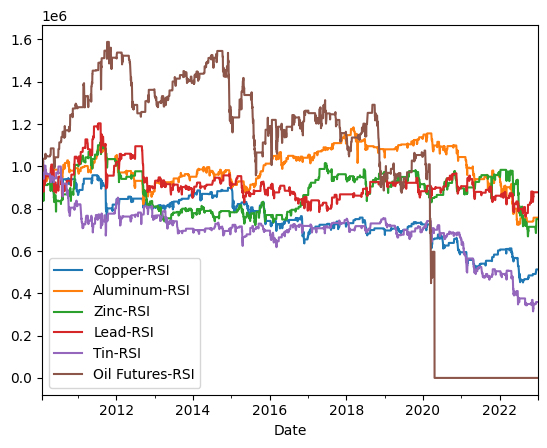

In [10]:
res.plot()
plt.show()

In [13]:
param_grid = {
    'rsi_window': [5, 10, 15, 20, 25],
    'long_threshold': [20, 25, 30, 35, 40],
    'short_threshold': [60, 65, 70, 75, 80],
    'leverage': [1, 2],
}

In [22]:
optimized_parameters, optimized_stats, optimized_backtest = hyperoptimisation(clean_data[["Zinc"]], param_grid, 0.5, 0.5)

|         |     Zinc-RSI |
|:--------|-------------:|
| Returns |  0.000886674 |
| Vol     |  0.0552758   |
| SR      |  0.0586253   |
| DD      | -0.0853974   |


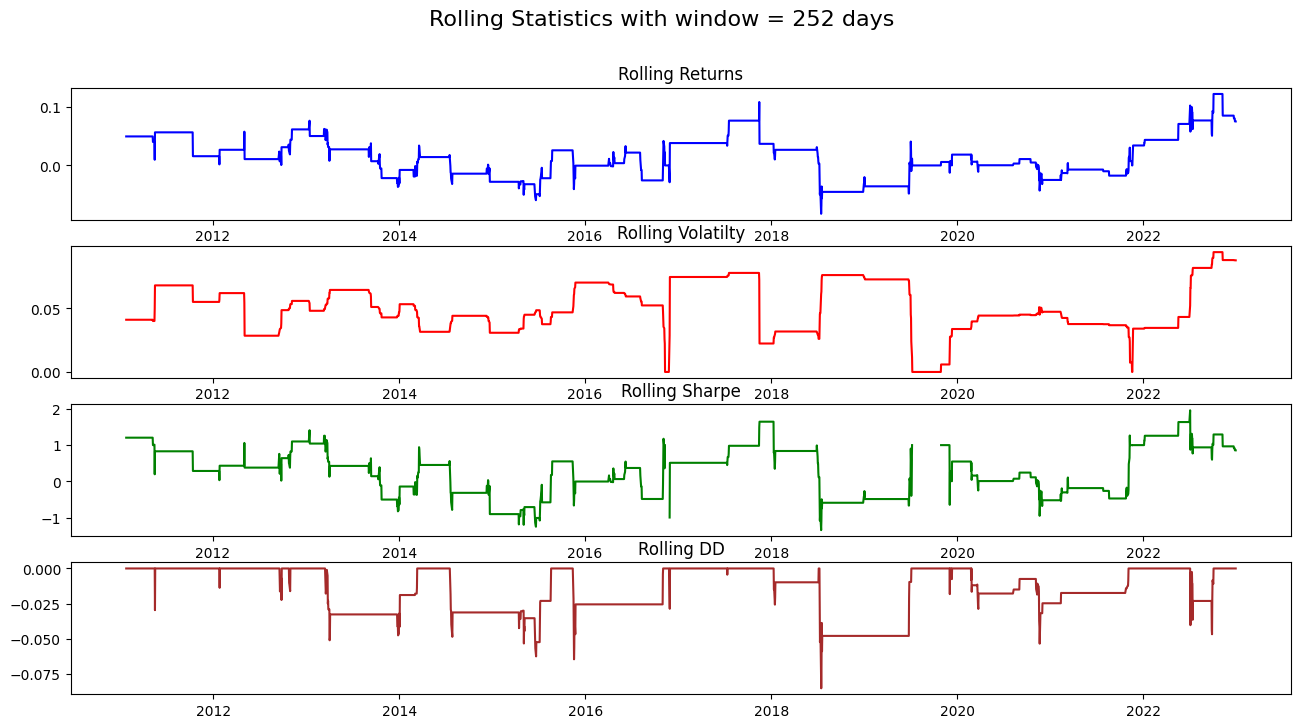

In [23]:
_, _, _, _ = compute_rolling_statistic(optimized_backtest, 252, plot=True)

In [20]:
optimized_parameters

{'start_dt': Timestamp('2010-01-01 00:00:00'),
 'end_dt': Timestamp('2022-12-30 00:00:00'),
 'initial_value': 1000000.0,
 'tc': 0.001,
 'rsi_window': 25,
 'leverage': 1,
 'long_threshold': 25,
 'short_threshold': 75}

In [15]:
optimized_stats.loc["SR"]["Zinc-RSI"] / stats.loc["SR"]["Zinc-RSI"]

-1.9355621681279485

In [18]:
benchmark_stats = compute_statistics(clean_data[["Zinc"]])

|         |         Zinc |
|:--------|-------------:|
| Returns |  0.000593017 |
| Vol     |  0.251374    |
| SR      |  0.00865387  |
| DD      | -0.492168    |


In [19]:
optimized_stats.loc["SR"]["Zinc-RSI"] / benchmark_stats.loc["SR"]["Zinc"]

6.774464426767781

<Axes: xlabel='Date'>

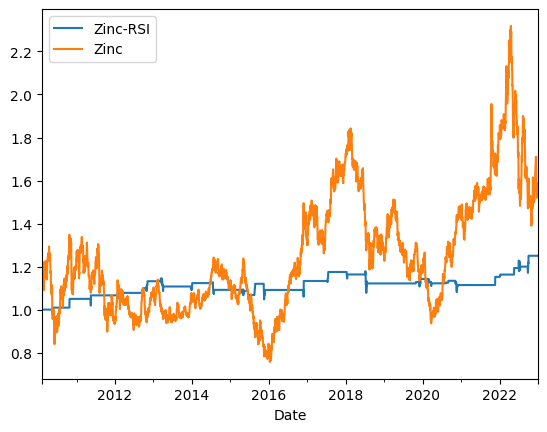

In [39]:
zinc_df = clean_data[["Zinc"]].loc[optimized_backtest.index]
compare_df = pd.concat([optimized_backtest, zinc_df], axis=1, ignore_index=False)
compare_df = rebase_df(compare_df, 1)
compare_df.plot()